In [180]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
# Load data
ground_truth = pd.read_csv("../source_data/test_preprocess.csv")
predictions = {
    "SVM": pd.read_csv('../evaluation/svm_predictions.csv'),
    "IndoBERT": pd.read_csv('../evaluation/bert_predictions.csv'),
    "GPT-4o Few-Shot V0": pd.read_csv('../evaluation/doc_for_improvement/few_shot_gpt-4o_predictions_v0.csv'),
    "GPT-4o Few-Shot V1": pd.read_csv('../evaluation/doc_for_improvement/few_shot_gpt-4o_predictions_v1.csv'),
    "GPT-4o Few-Shot V2": pd.read_csv('../evaluation/doc_for_improvement/few_shot_gpt-4o_predictions_v2.csv'),
    "GPT-4o Few-Shot V3": pd.read_csv('../evaluation/doc_for_improvement/few_shot_gpt-4o_predictions_v3.csv'),
    "GPT-4o Few-Shot V4": pd.read_csv('../evaluation/doc_for_improvement/few_shot_gpt-4o_predictions_v4.csv'),
    "GPT-4o Few-Shot V5": pd.read_csv('../evaluation/doc_for_improvement/few_shot_gpt-4o_predictions_v5.csv'),
}

# Configuration
aspect_keys = ["ac", "air_panas", "bau", "general", "kebersihan", 
               "linen", "service", "sunrise_meal", "tv", "wifi"]

FileNotFoundError: [Errno 2] No such file or directory: '../evaluation/doc_for_improvement/few_shot_gpt-4o_predictions.csv'

In [ ]:
def evaluate_model(true_df, pred_df, model_name):
    """Core evaluation function for a single model"""
    merged = true_df.merge(pred_df, on="review", suffixes=('_true', '_pred'))
    results = []
    
    for aspect in aspect_keys:
        y_true = merged[f"{aspect}_true"]
        y_pred = merged[f"{aspect}_pred"]
        
        report = classification_report(y_true, y_pred, 
                                      target_names=['neg', 'pos', 'neut'],
                                      output_dict=True)
        
        results.append({
            'model': model_name,
            'aspect': aspect,
            'accuracy': accuracy_score(y_true, y_pred),
            'macro_precision': report['macro avg']['precision'],
            'macro_recall': report['macro avg']['recall'],
            'macro_f1': report['macro avg']['f1-score'],
            'weighted_precision': report['weighted avg']['precision'],
            'weighted_recall': report['weighted avg']['recall'],
            'weighted_f1': report['weighted avg']['f1-score'],
            'neg_precision': report['neg']['precision'],
            'neg_recall': report['neg']['recall'],
            'neg_f1': report['neg']['f1-score'],
            'pos_precision': report['pos']['precision'],
            'pos_recall': report['pos']['recall'],
            'pos_f1': report['pos']['f1-score'],
            'neut_precision': report['neut']['precision'],
            'neut_recall': report['neut']['recall'],
            'neut_f1': report['neut']['f1-score'],
            'support': report['weighted avg']['support']
        })
    
    return pd.DataFrame(results)

# Main evaluation pipeline
all_results = []
for model_name, pred_df in predictions.items():
    print(f"Evaluating {model_name}...")
    model_results = evaluate_model(ground_truth, pred_df, model_name)
    all_results.append(model_results)

# Generate key outputs
full_results = pd.concat(all_results, ignore_index=True)

Evaluating SVM...
Evaluating IndoBERT...
Evaluating GPT-4o Few-Shot V0...
Evaluating GPT-4o Few-Shot V1...
Evaluating GPT-4o Few-Shot V2...
Evaluating GPT-4o Few-Shot V3...
Evaluating GPT-4o Few-Shot V4...
Evaluating GPT-4o Few-Shot V5...


In [ ]:
# 1. Model Comparison Table
model_comparison = full_results.groupby('model').agg({
    'accuracy': 'mean',
    'macro_precision': 'mean',
    'macro_recall': 'mean',
    'macro_f1': 'mean',
    'weighted_precision': 'mean',
    'weighted_recall': 'mean',
    'weighted_f1': 'mean',
    'neg_precision': 'mean',
    'neg_recall': 'mean',
    'neg_f1': 'mean',
    'pos_precision': 'mean',
    'pos_recall': 'mean',
    'pos_f1': 'mean',
    'neut_precision': 'mean',
    'neut_recall': 'mean',
    'neut_f1': 'mean',
    'support': 'mean'
}).reset_index()

print("\n=== AVG Model Comparison ===")
model_comparison[["model", "accuracy"]].round(4)


=== AVG Model Comparison ===


,model,accuracy
0,GPT-4o Few-Shot V0,0.9455
1,GPT-4o Few-Shot V1,0.9462
2,GPT-4o Few-Shot V2,0.9500
3,GPT-4o Few-Shot V3,0.9594
4,GPT-4o Few-Shot V4,0.9605
5,GPT-4o Few-Shot V5,0.9612
6,IndoBERT,0.9608
7,SVM,0.9350


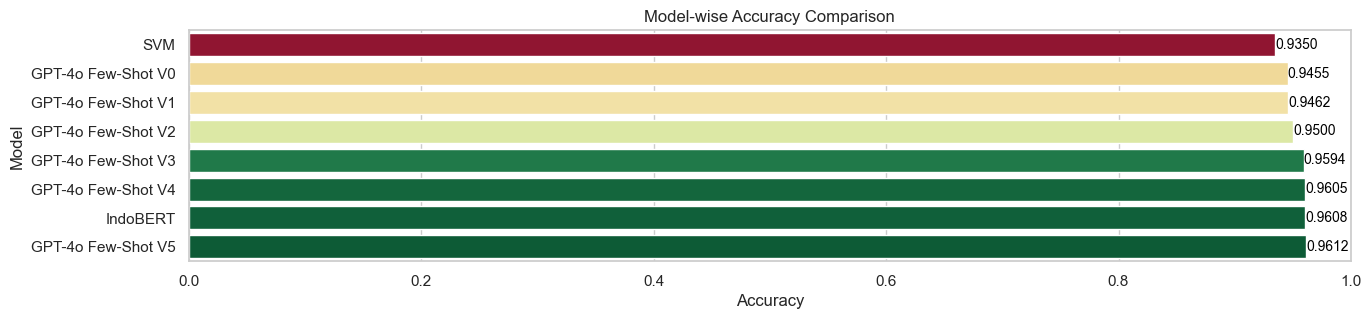

In [ ]:
sns.set_theme(style="whitegrid")
model_comparison = model_comparison.sort_values("accuracy", ascending=True)
norm = plt.Normalize(model_comparison["accuracy"].min(), model_comparison["accuracy"].max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
colors = [sm.to_rgba(val) for val in model_comparison["accuracy"]]
fig, ax = plt.subplots(figsize=(15, 3))
sns.barplot(data=model_comparison, x="accuracy", y="model", palette=colors, ax=ax)

# Annotate bars with accuracy values
for p in ax.patches:
    ax.annotate(f"{p.get_width():.4f}",
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black')

ax.set_xlabel("Accuracy")
ax.set_ylabel("Model")
ax.set_title("Model-wise Accuracy Comparison")
ax.set_xlim(0, 1)
plt.show()

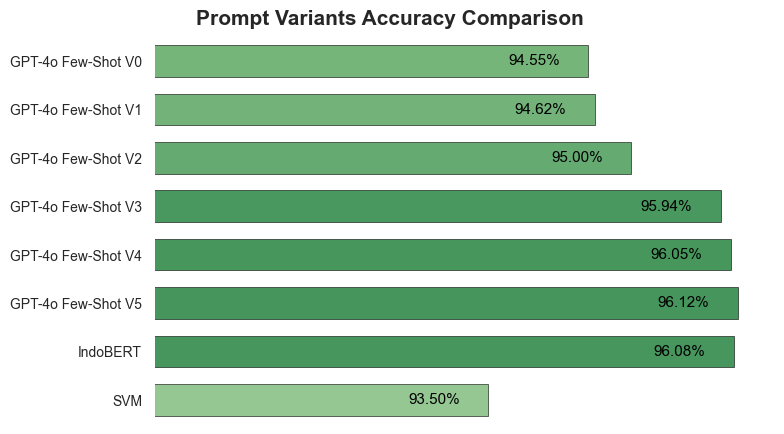

In [ ]:
# Define the desired order
desired_order = ["GPT-4o Few-Shot V0", "GPT-4o Few-Shot V1", "GPT-4o Few-Shot V2", 
                 "GPT-4o Few-Shot V3", "GPT-4o Few-Shot V4", "GPT-4o Few-Shot V5", 
                 "IndoBERT", "SVM"]

# Prepare data with custom ordering
model_comparison = (
    full_results.groupby('model')['accuracy']
    .mean()
    .reset_index()
    .round(4)
)
model_comparison['accuracy_pct'] = model_comparison['accuracy'] * 100
model_comparison['model'] = pd.Categorical(model_comparison['model'],
                                         categories=desired_order,
                                         ordered=True)
model_comparison = model_comparison.sort_values('model')

# Create custom light green colormap
light_greens = ["#e5f5e0", "#c7e9c0", "#a1d99b", "#74c476", 
                "#41ab5d", "#238b45", "#006d2c", "#00441b"]
cmap = LinearSegmentedColormap.from_list("light_greens", light_greens)
norm = plt.Normalize(90, 100)

# Create figure
plt.figure(figsize=(8, 4.5))
ax = sns.barplot(
    data=model_comparison,
    x="accuracy_pct",
    y="model",
    palette=[cmap(norm(acc)) for acc in model_comparison["accuracy_pct"]],
    width=0.65,
    edgecolor="black",
    linewidth=0.4
)

# Customize annotations
for p in ax.patches:
    width = p.get_width()
    ax.annotate(
        f"{width:.2f}%",
        (width - 0.3, p.get_y() + p.get_height()/2),
        ha='right',
        va='center',
        color='black',  # Dynamic text color
        fontsize=11,
        # fontweight='bold'
    )

# Title
plt.title("Prompt Variants Accuracy Comparison", 
          fontsize=15,
          fontweight='bold',
          y=1.01,
          x=0.38)

# Clean axis
plt.xlabel("")
plt.ylabel("")
plt.xlim(90, 96.5)
plt.xticks([])
plt.yticks(fontsize=10)

# Grid and spines
ax.xaxis.grid(True, linestyle=':', alpha=0.2)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

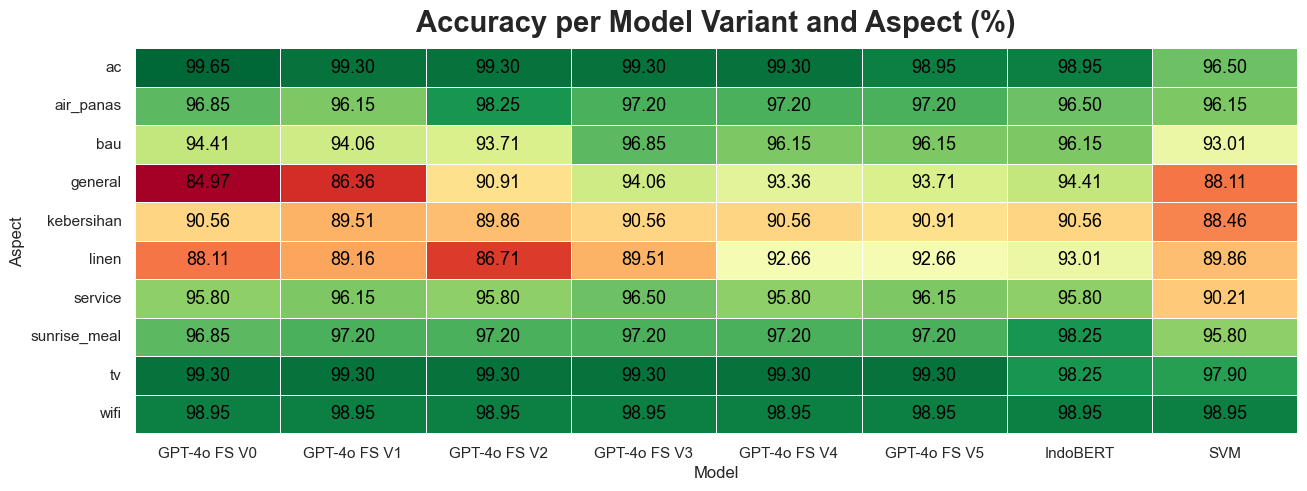

In [ ]:
# Apply aliasing to model names
heatmap_data = full_results.pivot_table(index="aspect", columns="model", values="accuracy", aggfunc="mean")
model_name_mapping = {
    'GPT-4o Few-Shot V0': 'GPT-4o FS V0',
    'GPT-4o Few-Shot V1': 'GPT-4o FS V1',
    'GPT-4o Few-Shot V2': 'GPT-4o FS V2', 
    'GPT-4o Few-Shot V3': 'GPT-4o FS V3',
    'GPT-4o Few-Shot V4': 'GPT-4o FS V4',
    'GPT-4o Few-Shot V5': 'GPT-4o FS V5',
    'IndoBERT': 'IndoBERT',
    'SVM': 'SVM'
}
heatmap_data = heatmap_data.rename(columns=model_name_mapping)  # Rename model names

# Create heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(
    heatmap_data * 100,
    annot=True,
    cmap="RdYlGn",
    fmt=".2f",
    linewidths=0.5,
    cbar=False,
    annot_kws={"color": "black", "size": 13}
)

plt.title("Accuracy per Model Variant and Aspect (%)", fontsize=21, fontweight='bold', pad=12)
plt.xlabel("Model")
plt.ylabel("Aspect")
plt.xticks(rotation=0)  # Ensure readability of the new labels
plt.show()
